In [1]:
from IPython.core.display import HTML
from string import Template
def jsConfig():
    src = """
    <script>require.config({ baseUrl: 'https://rawgit.com/kompgraf/course-material/master/assets/' });</script>
    """
    return HTML(src)
def addScript(script, identifier):
    src = Template("""
    <div id="${identifier}-container"></div>
    <script>require(['${script}'], main => main($$("#${identifier}-container"), '${identifier}'));</script>
    """)
    return HTML(src.substitute(script = script, identifier = identifier))
jsConfig()


# Subdivision-görbe

## Bevezetés

Az eddigi jegyzetekben görbék úgynevezett paraméteres előállítási módjaival foglalkoztunk. Ezek polinomfüggvények segítségével állították elő a görbepontokat, s egyúttal stabil matematikai alapot is adtak, egyszerűvé téve a görbe különböző tulajdonságainak vizsgálatát.

A *subdivision*-módszerek másfajta megközelítést alkalmazva törekednek görbék előállítására. E jegyzetben több különböző subdivision-módszer kerül bemutatásra.

## Az ötlet

A subdivision-görbék alapötletét George Chaikin fogalmazta meg 1974-ben. Ahelyett, hogy megfelelő polinomot alkalmaznánk, ami egy kívánatos tulajdonságokkal rendelkező görbét képez, valamilyen generatív eljárást definiálunk, ami közvetlenül a kontrollpoligonnal dolgozik. Az eljárás lényege, hogy a kontrollpoligont sorozatos finomításoknak vetjük alá. Minden egyes finomítást követően egy új, a megelőzőnél több kontrollpontból álló kontrollpoligon jön létre. A cél, hogy tetszőleges számú iteráció után a kontrollpoligon valamilyen megfelelő, sima görbéhez konvergáljon. 

A Chaikin-féle eljárás egy úgynevezett *corner-cutting* séma, mely minden iteráció során a kontrollpoligon sarkait kerekíti le, ilyen módon közelítve egy sima görbét. A finomítások során minden két egymást követő kontrollpontpárt összekötő szakaszon két új kontrollpontot helyezünk el. Az egyik pont a szakasz $\frac{1}{4}$, a másik a szakasz $\frac{3}{4}$ értéknél levő osztópontja lesz. Az így kapott pontok összekötése adja a következő kontrollpoligont.

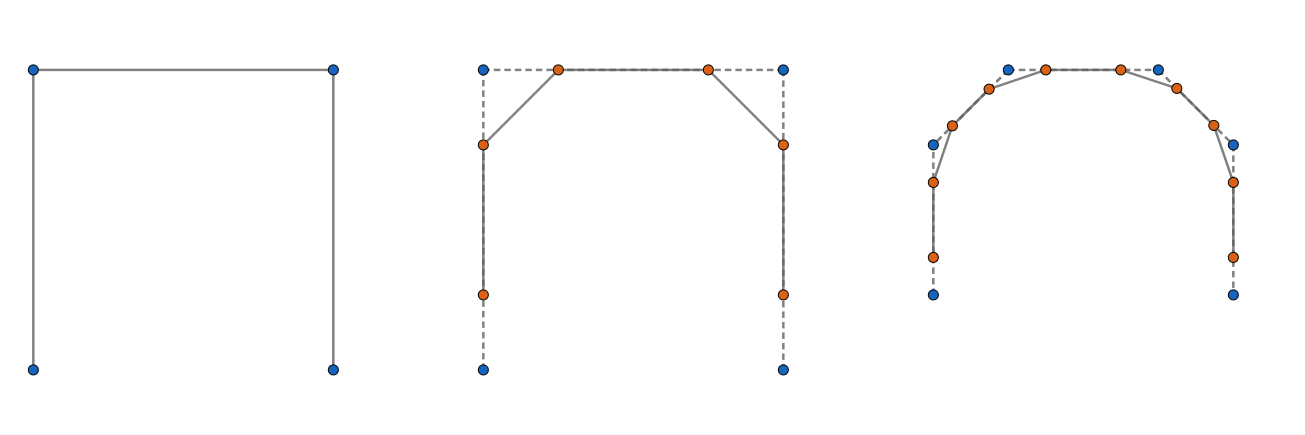
<div style="text-align:center">A Chaikin-féle subdvision eljárás két finomítása</div>

A Chaikin-féle eljárás, és általában a subdivision előnye, hogy rendkívül szemléletes, ennek folytán könnyen érthető, valamint egyszerűen implementálható. Hátránya azonban, hogy nem mindig egyértelmű, hogy mi garantálja azt, hogy a finomítások után előálló kontrollpoligon valóban egy sima görbe lesz. 

## A subdivision-módszerek leírása

Legyenek az eredeti kontrollpoligont alkotó pontok $P^0_0, P^0_1, P^0_2, \ldots, P^0_{n_0}$! Általánosan, az $i$-edik finomítás után előállíó kontrollpoligont jelölje $P^i$, ennek a $j$-edik pontját pedig $P^i_j$, ahol $j \leq 0 \leq n_i$.

A módszerek sokszínűsége miatt ennél többet általánosan már nem tudunk mondani. Bár az eddigi megfogalmazásokból úgy tűnhet, még az sem kötelező, hogy a finomítások növeljék a kontrollpontok számát. Az egyik legismertebb subdivision-módszer, a *de Casteljau*-algoritmus például minden iteráció alkalmával csökkenti a kontrollpontok számát, addig, míg egy görbepont elő nem áll.

### Jellemzők

Habár a subdivision-módszerek rendkívül sokszínűek, van néhány jellemző, melynek mentén osztályokba sorolhatóak.

#### Kontrollpontok száma

Ha az egyes finomítások növelik a kontrollpontok számát, akkor a módszert **increasing**nek nevezzük. Ekkor a végső $Q$ görbe (feltéve, hogy az alkalmazott subdivision-módszer megfelelő tulajdonságú) tetszőleges sok iteráció alkalmazásának eredménye lesz, azaz

$$
Q = \lim_{n \rightarrow \infty} P^n.
$$

Ellenkező esetben **decreasing** eljárásról beszélhetünk.

#### Felhasznált kontrollpontok

Amennyiben a soron következő finomítás egy adott kontrollpontját az aktuális kontrollpoligonnak csak kevés pontja határozza meg, úgynevezett **locality** sémáról beszélünk.

#### A kontrollpontok előállításának módja az egyes pontok függvényében

Ha minden új kontrollpontot azonos módon számolunk ki, akkor az eljárás **stationary**, egyébként **non-stationary**. Utóbbi esetben azt, hogy hányféle szabályt alkalmazunk, a módszer **aritásának** (**arity**) nevezzük. A Chaikin-módszer például bináris (**binary**).

#### A kontrollpontok előállításának módja a finomítások függvényében

Egy séma **uniform** abban az esetben, ha függetlenül attól, hogy hanyadik iterációnál tartunk, a finomítás végrehajtásának módja azonos. Azaz nem változik a finomítási séma az iterációk számának növekedésével.

### A subdivision-maszk

Vizsgáljunk most meg egy rendkívül rugalmas definíciót, melynek segítségével leírhatóak az olyan subdivision-módszerek, melyek a soron következő finomítás során csak az aktuális kontrollpoligont használják.

Álljon elő a finomított kontrollpoligon egy adott pontja a megelőző (vagyis aktuális) kontrollpoligon pontjainak lineáris kombinációjaként:

$$
P^k_j = \sum\limits_{i = 0}^{n_{k - 1}}\alpha_{i, j, k}P^{k-1}_i .
$$

Adott $j$ és $k$ esetén az $\alpha_{i, j, k}$ $(i = 0, 1, \ldots, n_{k-1})$ értékek egy úgynevezett subdivision *maszk*ot alkotnak.

Ha egy séma **locality** tulajdonsággal bír, akkor a maszkot javarészt $0$ értékek alkotják. **Uniform** tulajdonság esetén bármely $k$-ra azonos lesz a séma. Végül, ha $j$ nem befolyásolja a maszkot alkotó értékeket, akkor a séma **stationary**. Ezeken felül a subdivision-maszk **increasing** és **decreasing** módszerek leírását is lehetővé teszi.

## Példák

### de Casteljau-algoritmus

Írjuk le maszk segítségével a de Castaljau-algoritmust egy adott $t$ paraméterérték esetén! Ismétlésül, adott $t$ esetén az algoritmus az egymást követő kontrollpontokat összekötő szakasz $t$-nek megfelelő osztópontját képzi. Ezt addig folytatja, amíg már nincsen több szakasz, azaz előállt egyetlent pont, amely a Bézier-görbe $t$ paraméterértékhez tartozó pontja lesz.

Tehát

$$
P^k_j = (1 - t) \cdot P^{k - 1}_j + t \cdot P^{k - 1}_{j + 1} \qquad j = 0, 1, \ldots, n_{k - 1} - 1,
$$

azaz bármely $k$ (ami azt jelenti, hogy akárhanyadik finomítási iteráció $\rightarrow$ **uniform**) és bármely $j$ (azaz mindegyik kontrollpont $\rightarrow$ **stationary**) esetén

$$
\begin{align*}
    \alpha_{j, j, k} &= 1 - t \\
    \alpha_{j + 1, j, k} &= t \\
    \alpha_{i, j, k} &= 0  \quad \text{ ha } i \neq j \text{ és } i \neq j + 1
\end{align*}
$$

Mivel a sorozatos finomítások csökkentik a kontrollpontok számát, ezért ez egy **decreasing** subdivision-módszer lesz, ami jól látszik a számítást illusztráló ábrán is.

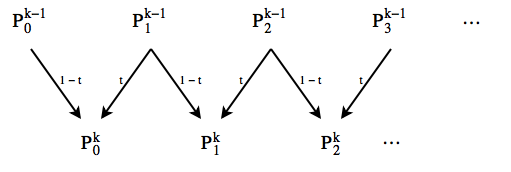

<div style="text-align: center">A de Casteljau-algoritmus $k$-adik finomítása</div>

### Chaikin-módszer

Folytassuk a jegyzet elején is említett Chaikin-módszer maszkot alkalmazó leírásával! Ahogyan az ábráról is leolvasható, ez az eljárás **increasing** lesz; minden finomítás kétszeresére növeli a kontrollpontok számát. 

A módszer lényege, hogy az egymást követő kontrollpontokat összekötő szakaszokon két új kontrollpontot helyezünk el. E két pontot különböző módon kell számolnunk, azaz az eljárás ** binary non-stationary**.

A finomított kontrollpoligon páros indexű pontjait a következő képlet alapján számolhatjuk:

$$
P^{k}_{2j} = \frac{3}{4} P^{k-1}_{j} + \frac{1}{4} P^{k-1}_{j + 1} \qquad j = 0, 1, \ldots, n_{k-1} - 1.
$$

A páratlan indexűeket pedig szimmetrikus módon:

$$
P^{k}_{2j + 1} = \frac{1}{4} P^{k-1}_{j} + \frac{3}{4} P^{k-1}_{j + 1} \qquad j = 0, 1, \ldots, n_{k-1} - 1.
$$

Így a maszkot a következőképpen definiálhatjuk. Ha $j$ páros, akkor 

$$
\begin{align*}
\alpha_{\frac{j}{2}, j, k} &= \frac{3}{4} \\
\alpha_{\frac{j}{2} + 1, j, k} &= \frac{1}{4}
\end{align*}
$$

a maszk többi eleme pedig $0$. Ha $j$ páratlan, akkor szintén csak két $0$-tól különböző elem lesz:

$$
\begin{align*}
\alpha_{\frac{j - 1}{2}, j, k} &= \frac{1}{4} \\
\alpha_{\frac{j - 1}{2} + 1, j, k} &= \frac{3}{4}
\end{align*}.
$$

#### Demonstráció

A következő demonstráció Chaikin-módszerrel előállított subdivision-görbét mutat be. A kék téglalapba kattintva tudunk elhelyezni kontrollpontokat. Három kontrollpont elhelyezését követően megkezdődik a görbe kirajzolása.

A *Finomítás* feliratú gomb segítségével hajthatunk végre egy finomítási iterációt. Ha már legalább egy finomítást végeztünk, akkor a kontrollpontok már *nem* lesznek mozgathatóak, és új kontrollpontok sem lesznek elhelyezhetőek. Ahhoz, hogy új görbét állíthassunk elő, a *Pontok törlése* gombra kattintva előbb ki kell törölnünk a meglevő kontrollpontokat.

In [2]:
addScript("js/chaikin-subdivision", "chaikin-subdivision")

## Midpoint Subdivision

A midpoint subdivision eljárások egy családját jelenti, melyeknek közös jellemzője, hogy mindegyik egymást követő kontrollpontot összekötő szakasz felezőpontján elhelyeznek egy új kontrollpontot. Ezek az újonnan képzett pontok, és az aktuális kontrollpoligon pontjainak valamilyen elmozdításával kapott pontok fogják alkotni az új kontrollpoligont. Így egy finomítási iterációt követően, ha $n + 1$ pontból indultunk ki, akkor $2n + 1$ kontrollpontunk lesz.

A jegyzetben csak egy példát fogunk megvizsgálni, mely a következő módon működik. Először képezzünk a midpointokat! Ezután mozgassuk el az aktuális kontrollpoligon minden egyes pontját a szomszédainak függvényében:

$$
P_i^{\prime}=(1-2s)P_i + sP_{i - 1} + sP_{i + 1},
$$

ahol $s$ azt befolyásolja, hogy a szomszédok milyen súllyal szólnak bele az új pont pozíciójába. Végül az így kapott pontokat adjuk hozzá az új kontrollpoligonhoz. Vegyük észre, hogy ez a séma szimmetrikus, hiszen a megelőző és a rákövetkező szomszéd is azonos súllyal rendelkezik. Felírható azonban a képlet pontonként eltérő súlyokkal is.

### Definíció maszk segítségével

#### Végpontok

Mivel az első kontrollpontnak nincsen megelőzője, az utolsónak pedig rákövetkezője, így ezeket nem fogjuk elmozdítani. Tehát bármely $k$ esetén, ha $j = 0$ vagy $j = n_k$, akkor 

$$
\alpha_{i, j, k} = 0 \qquad \forall i
$$

#### Midpointok

Következzenek a midpointok! Ezek a páratlan indexű pontok lesznek:

$$
P^{k}_{2j + 1} = \frac{1}{2}P^{k - 1}_{j} + \frac{1}{2}P^{k - 1}_{j + 1} \qquad j = 0, 1, \ldots, n_{k - 1} - 1,
$$

azaz a maszk a következő módon alakul:

$$
\begin{align*}
\alpha_{\frac{j - 1}{2}, j, k} &= \frac{1}{2} \\
\alpha_{\frac{j - 1}{2} + 1, j, k} &= \frac{1}{2}
\end{align*}.
$$

#### Elmozdított pontok

A páros indexű pontok az elmozdított pontoknak fognak megfelelni, melyek meghatározását az előzőleg felírt képlettel végezzük:

$$
P^{k}_{2j}=(1-2s)P^{k - 1}_j + sP^{k - 1}_{j - 1} + sP^{k - 1}_{j + 1} \qquad j = 1, \ldots, n_{k - 1} - 1,
$$

ennek következtében a maszk:

$$
\begin{align*}
\alpha_{\frac{j}{2}, j, k} &= 1 - 2s \\
\alpha_{\frac{j}{2} - 1, j, k} &= s \\
\alpha_{\frac{j}{2} + 1 , j, k} &= s
\end{align*}.
$$

### Demonstráció

A demonstráció az előzőleg felírt midpoint subdivision működését mutatja be, $s = \frac{1}{8}$ esetén. A demonstráció ugyanúgy kezelhető, mint a Chakinin-módszert szemléltető demó.

In [3]:
addScript("js/midpoint-subdivision", "midpoint-subdivision")

## Források

* J. F. Hughes, A. van Dam (2013). *Computer Graphics: Principles and Practice*, Third Edition, Chapter 22W, pp. 130-138. http://dept.cs.williams.edu/~morgan/cgpp/file/cgpp3e_ch22W.pdf
* G. M. Chaikin (1974). An Algorithm for High-Speed Curve Generation
* K. Joy. Refinement. http://graphics.cs.ucdavis.edu/education/CAGDNotes/Refinement/Refinement.html

In [4]:
def styling():
    styles = open("../../styles/custom.html", "r").read()
    return HTML(styles)
styling()
